In [1]:
import numpy as np
import pandas as pd
import os
from nilearn.connectome import ConnectivityMeasure
import pingouin
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import time
import pickle

In [2]:
data = pd.read_csv("Phenotypic_V1_0b_preprocessed1.csv")

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,0,1,50002,1,50002,PITT,no_filename,1,1,16.77,...,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1


In [3]:
path = "data_roi_time_series/Outputs/ccs/filt_global/rois_aal/"
files = os.listdir(path)

In [103]:
iq_type = 'VIQ'

In [104]:
filenames = []
data = data[data['DX_GROUP']==2]
num_subjects = len(files)
for i in range(num_subjects):
    temp = files[i].split('_')
    idx = temp.index('rois')
    name = '_'.join(temp[:idx])
    if name in data['FILE_ID'].values:
        df = data[data['FILE_ID']==name]
        if not (np.isnan(df[iq_type].values[0])):
            if df[iq_type].values[0] != -9999:
                filenames.append(name)

391

In [105]:
all_subjects = [[]]*len(filenames)
i = 0
for file in filenames:
    f = open(path+file+'_rois_aal.1D','r')
    temp = [line.split() for line in f]
    all_subjects[i] = np.array(temp[1:]).astype('float64')
    i += 1

9.290422677993774


In [106]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(all_subjects)

In [108]:
with open (iq_type.lower()+'_pos_significant', 'rb') as fp:
    pos_significant = pickle.load(fp)
    
with open (iq_type.lower()+'_neg_significant', 'rb') as fp:
    neg_significant = pickle.load(fp)

In [109]:
pos_score = [0]*len(all_subjects)
neg_score = [0]*len(all_subjects)
for i in range(len(all_subjects)):
    for j in range(len(pos_significant)):
        pos_score[i] += correlation_matrices[i,pos_significant[j][0],pos_significant[j][1]]
    for j in range(len(neg_significant)):
        neg_score[i] += correlation_matrices[i,neg_significant[j][0],neg_significant[j][1]]

In [110]:
mod_data = data[data['DX_GROUP']==2]
iq_data = mod_data[['FILE_ID','VIQ','FIQ','PIQ']]
iq_data = iq_data[iq_data['FILE_ID'].isin(filenames)]

In [111]:
iq_data = iq_data[['FILE_ID',iq_type]]
iq_data = iq_data.dropna()
iq_data = iq_data[iq_data[iq_type] != -9999]
iq_data['pos_score'] = np.nan
iq_data['neg_score'] = np.nan


In [112]:
for i in range(len(all_subjects)):
    if filenames[i] in iq_data['FILE_ID'].values:
        iq_data.loc[iq_data['FILE_ID']==filenames[i],'pos_score'] = pos_score[i]
        iq_data.loc[iq_data['FILE_ID']==filenames[i],'neg_score'] = neg_score[i]

[]

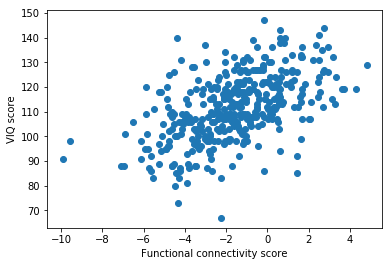

In [113]:
plt.scatter(iq_data['pos_score'],iq_data[iq_type])
plt.xlabel('Functional connectivity score')
plt.ylabel(iq_type+' score')
plt.show()

In [114]:
def model(dataset, iq_type, score_type):
    train,test = train_test_split(dataset, test_size=0.2)    
    X_train = train[score_type].values
    X_train = X_train.reshape(-1,1)
    X_test = test[score_type].values
    X_test = X_test.reshape(-1,1)
    y_train = train[iq_type].values
    y_test = test[iq_type].values
    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    
    y_pred = reg.predict(X_test)
    c = pingouin.corr(y_test,y_pred)
    print('Training Mean squared error: %.2f'% mean_squared_error(y_train, reg.predict(X_train)))
    print('Testing Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))
    #print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred))
    #print(reg.coef_, reg.intercept_)
    plt.plot(X_test,y_pred, color='black')
    plt.scatter(X_test,y_test)
    plt.xlabel('Functional conectivity scores (testing data)')
    plt.ylabel('IQ')
    plt.legend(['Predicted IQ','Actual IQ'])
    plt.show()
    plt.scatter(y_test,y_pred)
    plt.xlabel('Actual IQ')
    plt.ylabel('Predicted IQ')
    return c

Training Mean squared error: 147.56
Testing Mean squared error: 120.72


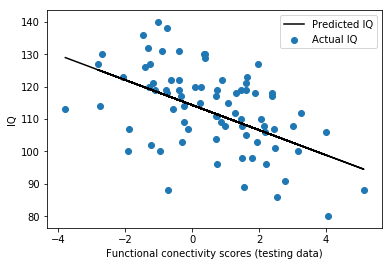

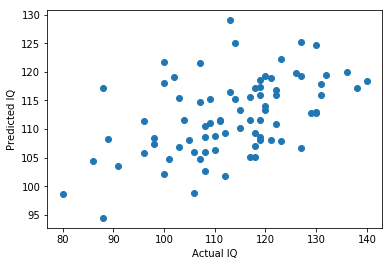

In [125]:
c = model(iq_data,iq_type,'neg_score')